# Tsallis network models

## Tsallis-Erdös-Rényi model

In [115]:
import os
import pickle

import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from tqdm import tqdm

from src.ensemble_generators import generate_tsallis_ensemble

### The free energy density

In [9]:
def H(x):
    # The binary Shannon entropy
    return -x*np.log(x) - (1-x)*np.log(1-x)

def phi(x, theta, r):
    # The free entropy density
    return (H(x) - 1/r*np.log(1 + r*x*theta))

#### Figure 4.1 - Plot the free entropy density for three different values of theta

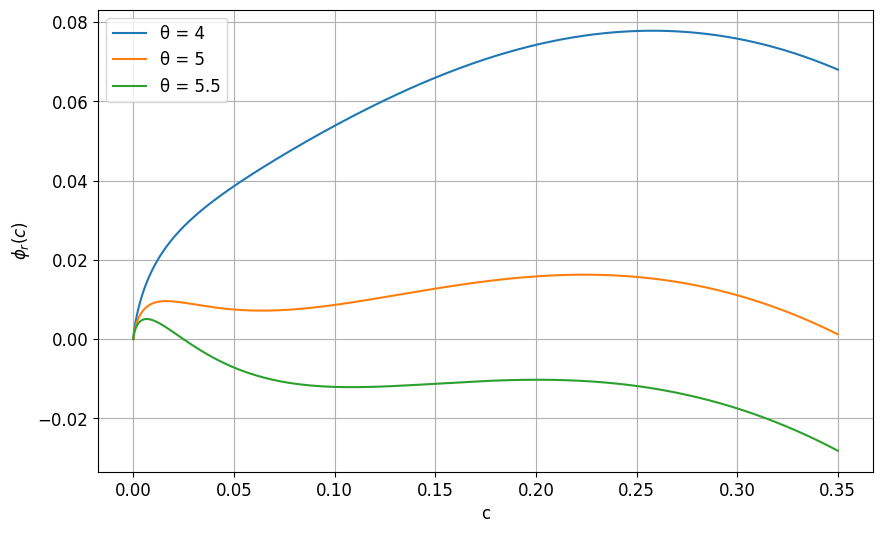

In [11]:
# Plot the free entropy density for three different values of theta
x = np.linspace(1e-6, 0.35, 1000)
r = 2.7
thetas = [4, 5, 5.5]

plt.figure(figsize=(10,6))

for theta in thetas:
    y = phi(x, theta, r)
    plt.plot(x, y, label=f'θ = {theta}')

plt.rcParams.update({'font.size': 12})

plt.xlabel('x')
plt.xlabel('c')
plt.ylabel(r'$\phi_r(c)$')
# plt.title(f'Potential $\phi_r(c)$ for r = {r} and different $\\theta$')
plt.legend()
plt.grid(True)



### Saddle point equation

#### Figure 4.3 - comparison of the left-hand side and right-hand side of the saddle-point equation

In [ ]:
# RHS of the saddle point equation
def rhs_saddle(c, theta, r):
    return 1/(1+np.exp(1/(1/theta + r*c)))

(0.0, 0.8)

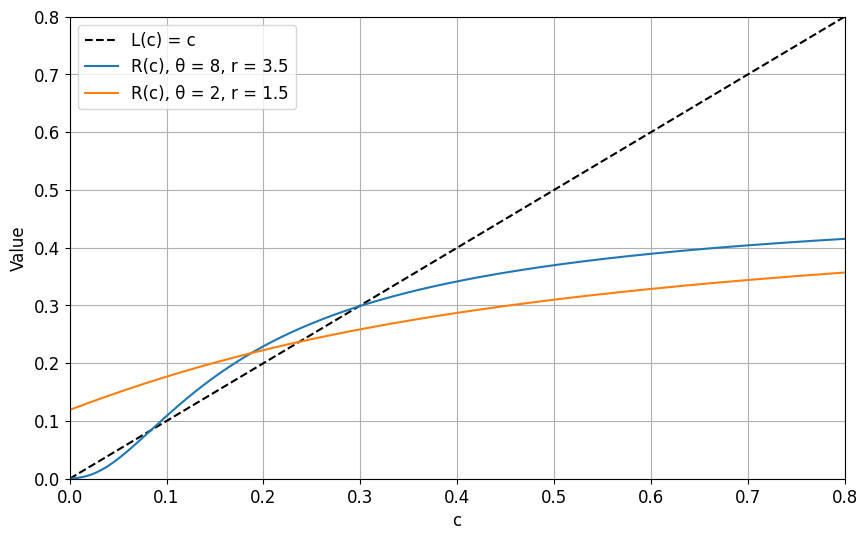

In [8]:
# Plot the RHS of the saddle point equation
c_array = np.linspace(0, 0.8, 1000)
rhs_values_1 = rhs_saddle(c_array, 8, 3.5)
rhs_values_2 = rhs_saddle(c_array, 2, 1.5)

plt.figure(figsize=(10, 6))

# Plot L(c) = c (the identity function)
plt.plot(c_array, c_array, 'k--', label='L(c) = c')

# Plot R(c) for the two parameter sets
plt.plot(c_array, rhs_values_1, label=f'R(c), θ = 8, r = 3.5')
plt.plot(c_array, rhs_values_2, label=f'R(c), θ = 2, r = 1.5')

plt.rcParams.update({'font.size': 12})
plt.xlabel('c')
plt.ylabel('Value')
# plt.title('Saddle Point Equation: L(c) vs R(c)')
plt.legend()
plt.grid(True)
plt.xlim(0, 0.8)
plt.ylim(0, 0.8)


### Phase transition

In [85]:
def saddle_point_equation(x, theta, r):
    return x - 1/(1+np.exp(1/(1/theta + r*x)))


In [44]:
def find_fixed_points(f, x_min, x_max, n_samples=1000):
    """
    Find fixed points of a function within a given interval.
    
    This function samples the given function at n_samples points within the interval
    [x_min, x_max] and looks for sign changes to detect zero crossings. It then uses
    the Brent method to find the precise location of each root. It also checks the
    endpoints of the interval.
    
    Parameters
    ----------
    f : callable
        The function for which to find fixed points (where f(x) = 0)
    x_min : float
        Lower bound of the interval to search
    x_max : float
        Upper bound of the interval to search
    n_samples : int, optional
        Number of sample points to use. Default is 1000.
        
    Returns
    -------
    numpy.ndarray
        Array of unique fixed points sorted in ascending order
    """
    xs = np.linspace(x_min, x_max, n_samples)
    fs = f(xs)

    roots = []
    # look for sign changes
    for i in range(len(xs)-1):
        if fs[i] == 0:
            roots.append(xs[i])
        elif fs[i]*fs[i+1] < 0:
            root = optimize.root_scalar(
                f, bracket=[xs[i], xs[i+1]],
                method='brentq'
            ).root
            roots.append(root)
    # Check endpoints
    if abs(f(x_min)) < 1e-10:
        roots.append(x_min)
    if abs(f(x_max)) < 1e-10:
        roots.append(x_max)
    return np.unique(np.round(roots, 8))

In [88]:
def find_stable_fixed_points(r, max_theta, saddle_point_equation, phi, lower_bound=-1, upper_bound=1, num_thetas=1e4):
    """
    Find local maxima of the effective free entropy potential using saddle point equation for a range of theta values.
    
    This function scans through theta values and finds stable fixed points of the saddle point equation.
    For each theta, it identifies local maxima and the global maximum of the effective free entropy.
    Assumes that if there are three fixed points, the local maxima are the first and third fixed points.
    This is used to detect phase transitions where the global maximum switches between two local maxima.
    
    Parameters
    ----------
    r : float
        Interaction strength parameter
    max_theta : float
        Maximum value of theta to scan
    saddle_point_equation : callable
        Function that takes (x, theta, r) and returns the saddle point equation
    phi : callable
        Function that takes (x, theta, r) and returns the effective free entropy
    lower_bound : float, optional
        Lower bound of the interval to scan. Default is -1.
    upper_bound : float, optional
        Upper bound of the interval to scan. Default is 1.
        
    Returns
    -------
    max_phi_arr : numpy.ndarray
        Array of maximum effective free entropy values for each theta
    global_maxima : numpy.ndarray
        Array of x values that maximize effective free entropy for each theta  
    local_maxima_arr : numpy.ndarray
        Array of local maxima pairs [max1, max2] for each theta
    thetas : numpy.ndarray
        Array of theta values scanned
    """
    thetas = np.linspace(0.01, max_theta, int(num_thetas))
    max_phi_arr = np.zeros(len(thetas))
    global_maxima = np.zeros(len(thetas))
    local_maxima_arr = np.zeros((len(thetas), 2))

    for i, theta in enumerate(thetas):
        fixed_points = find_fixed_points(lambda x: saddle_point_equation(x, theta, r), lower_bound, upper_bound, 1000)
        if fixed_points.size == 0:
            raise ValueError("No fixed points found for theta: ", theta)
        if len(fixed_points) > 2:
            local_maxima_arr[i] = [fixed_points[0], fixed_points[2]]
        elif len(fixed_points) == 2:
            print(f"Only two fixed points found for r: {r}, theta: {theta}")
            local_maxima_arr[i] = [fixed_points[0], fixed_points[1]]
        else:
            local_maxima_arr[i] = [fixed_points[0], fixed_points[0]]
        phi_values = phi(fixed_points, theta, r)
        max_phi_arr[i] = np.max(phi_values)
        maximizer_index = np.argmax(phi_values)
        global_maximum = fixed_points[maximizer_index]
        global_maxima[i] = global_maximum

    return max_phi_arr, global_maxima, local_maxima_arr, thetas

In [89]:
def track_fixed_points(r, max_theta,
                       saddle_eq, phi,
                       theta0=0.01, n_thetas=10000,
                       lower=-1, upper=1, fd_eps=1e-6):
    # 1) theta grid
    thetas = np.linspace(theta0, max_theta, int(n_thetas))
    # 2) initial scan at theta0
    current_roots = find_fixed_points(
        lambda x: saddle_eq(x, theta0, r),
        lower, upper, n_samples=2000
    )

    # storage arrays
    max_phi        = np.zeros(len(thetas))
    global_max_x   = np.zeros(len(thetas))
    local_maxima   = np.zeros((len(thetas), 2))

    for i, theta in enumerate(thetas):
        if i > 0:
            new_roots = []
            for x0 in current_roots:
                # define f for this theta
                fₜ = lambda x: saddle_eq(x, theta, r)
                try:
                    # Newton with finite‐diff Jacobian
                    root = optimize.newton(
                        func=fₜ,
                        x0=x0,
                        fprime=lambda x: optimize.approx_fprime(
                            np.atleast_1d(x), fₜ, fd_eps
                        )[0],
                        tol=1e-8,
                        maxiter=20
                    )
                except Exception:
                    # fallback: secant method
                    root = optimize.root_scalar(
                        fₜ,
                        method='secant',
                        x0=x0,
                        x1=x0 + 1e-3,
                        xtol=1e-8
                    ).root
                new_roots.append(root)

            # dedupe & clip
            current_roots = np.unique(
                np.clip(new_roots, lower, upper).round(8)
            )

        # pick presumed local maxima
        cps = np.sort(current_roots)
        if cps.size > 2:
            local_maxima[i] = [cps[0], cps[2]]
        elif cps.size == 2:
            local_maxima[i] = [cps[0], cps[1]]
        else:
            local_maxima[i] = [cps[0], cps[0]]

        # evaluate phi
        phivalues = phi(cps, theta, r)
        idx = np.argmax(phivalues)
        max_phi[i]      = phivalues[idx]
        global_max_x[i] = cps[idx]

    return max_phi, global_max_x, local_maxima, thetas

#### Figure 4.2 - the link density for r=2 and r=2.7. For r=2.7, we observe the phase transition

r=2.7

In [119]:
_, global_maxima_1, local_maxima_arr_1, thetas_1 = find_stable_fixed_points(r=2.7, max_theta=8, saddle_point_equation=saddle_point_equation, phi=phi, lower_bound=0, upper_bound=1)

r=2

In [120]:
min_phi_arr_2, global_maxima_2, local_maxima_arr_2, thetas_2 = find_stable_fixed_points(r=2, max_theta=8, saddle_point_equation=saddle_point_equation, phi=phi, lower_bound=0, upper_bound=1)

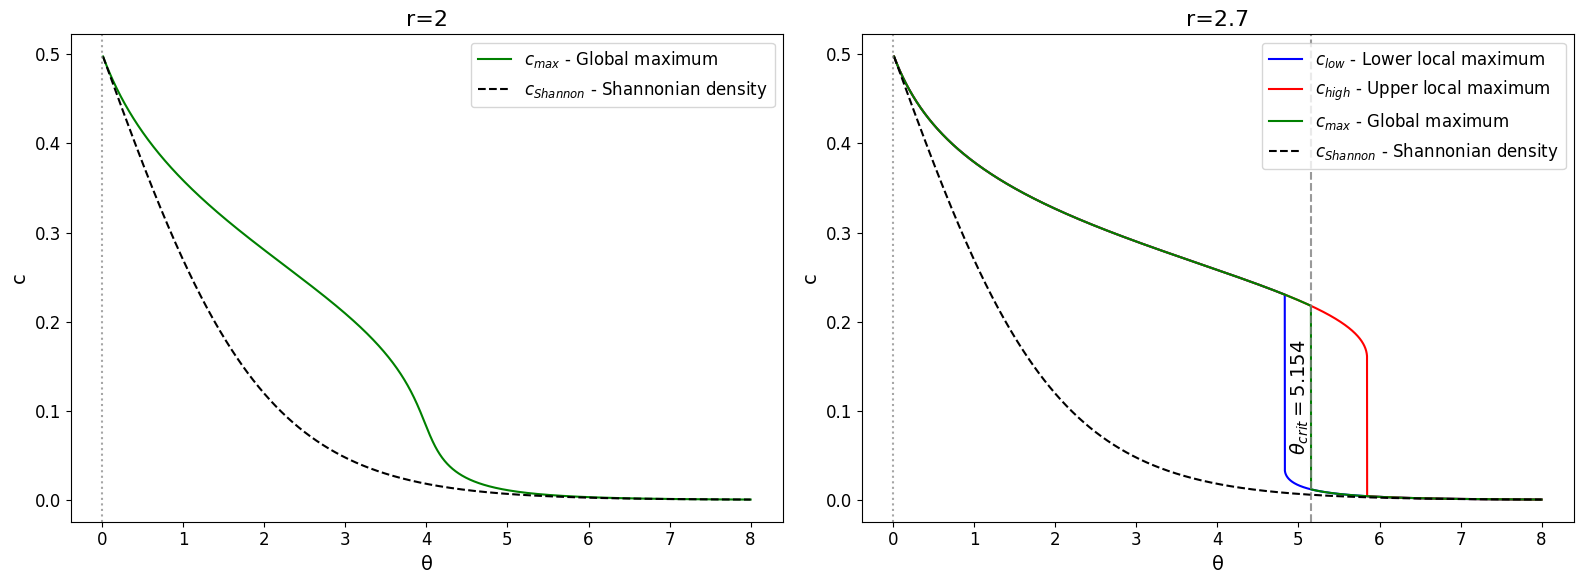

In [124]:
# Create a figure with two subplots side by side
plt.figure(figsize=(16, 6))

# Set font sizes
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16
LEGEND_SIZE = 12

# Update font sizes
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LEGEND_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# First subplot (r=2)
plt.subplot(1, 2, 1)
plt.plot(thetas_2, global_maxima_2, 'g-', label='$c_{max}$ - Global maximum')
# Calculate the sigmoid function values for each theta
sigmoid_values_2 = 1/(1+np.exp(thetas_2))
# Add the sigmoid plot
plt.plot(thetas_2, sigmoid_values_2, 'k--', label='$c_{Shannon}$ - Shannonian density')
# Add a vertical line at theta = 0 for reference
plt.axvline(x=0, color='gray', linestyle=':', alpha=0.7)
plt.xlabel('θ')
plt.ylabel('c')
plt.title('r=2')
plt.legend()

# Second subplot (r=2.7)
plt.subplot(1, 2, 2)
plt.plot(thetas_1, local_maxima_arr_1[:,0], 'b-', label='$c_{low}$ - Lower local maximum')
plt.plot(thetas_1, local_maxima_arr_1[:,1], 'r-', label='$c_{high}$ - Upper local maximum')
plt.plot(thetas_1, global_maxima_1, 'g-', label='$c_{max}$ - Global maximum')
# Calculate the sigmoid function values for each theta
sigmoid_values = 1/(1+np.exp(thetas_1))
# Add the sigmoid plot
plt.plot(thetas_1, sigmoid_values, 'k--', label='$c_{Shannon}$ - Shannonian density')
# Add a vertical line at theta = 0 for reference
plt.axvline(x=0, color='gray', linestyle=':', alpha=0.7)
# Add a vertical line at the critical theta value
plt.axvline(x=5.154, color='gray', linestyle='--', alpha=0.8)
# Add text annotation for the critical theta
plt.text(5.154, 0.05, r'$\theta_{crit} = 5.154$', rotation=90, verticalalignment='bottom', horizontalalignment='right', fontsize=MEDIUM_SIZE)
plt.xlabel('θ')
plt.ylabel('c')
plt.title('r=2.7')
plt.legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

#### Figure 4.4 - The phase diagram

In [52]:
def find_critical_thetas(local_maxima_arr, global_maxima, thetas):
    """
    Find critical theta values where phase transitions occur in the system.
    
    This function analyzes the local maxima and global maximum arrays to identify three critical theta values:
    1. theta_lower: The theta value where the system first exhibits two distinct local maxima
    2. theta_transition: The theta value where the global maximum switches from one local maximum to the other
    3. theta_upper: The theta value where the system returns to having a single maximum
    
    Parameters:
    -----------
    local_maxima_arr : numpy.ndarray
        Array of shape (n, 2) containing the values of two local maxima for each theta value
    global_maxima : numpy.ndarray
        Array of shape (n,) containing the global maximum value for each theta
    thetas : numpy.ndarray
        Array of theta values corresponding to the maxima arrays
        
    Returns:
    --------
    tuple
        (theta_lower, theta_transition, theta_upper)
        If any transition is not detected, the corresponding value will be np.nan
    """
    threshold = 1e-6
    
    # Find indices where local maxima differ
    diff_indices = np.where(np.abs(local_maxima_arr[:,0] - local_maxima_arr[:,1]) > threshold)[0]
    
    # If no differences detected, return NaN values
    if len(diff_indices) == 0:
        return np.nan, np.nan, np.nan
    
    # Find transition points
    theta_lower = thetas[diff_indices[0]]
    theta_upper = thetas[diff_indices[-1]]
    
    # Find where global maximum switches
    post_transition_indices = np.where(thetas > theta_lower)[0]
    
    if len(post_transition_indices) == 0:
        return theta_lower, np.nan, theta_upper
    
    # Determine which local maximum starts as the global maximum
    first_post_idx = post_transition_indices[0]
    initial_global_is_second = np.abs(global_maxima[first_post_idx] - local_maxima_arr[first_post_idx, 1]) < threshold
    target_col = 0 if initial_global_is_second else 1
    
    # Find the transition point where global maximum switches
    for i in post_transition_indices:
        if np.abs(global_maxima[i] - local_maxima_arr[i, target_col]) < threshold:
            return theta_lower, thetas[i], theta_upper
    
    return theta_lower, np.nan, theta_upper

In [93]:
r_values = np.linspace(2, 8, 400)
max_theta = 30
transition_thetas_networks= np.zeros((len(r_values),3))
global_maxima_all = []
local_maxima_arr_all = []
for i, r in enumerate(tqdm(r_values)):
    _, global_maxima, local_maxima_arr, thetas = find_stable_fixed_points(r, max_theta=max_theta, saddle_point_equation=saddle_point_equation, phi=phi, lower_bound=0, upper_bound=1)
    global_maxima_all.append(global_maxima)
    local_maxima_arr_all.append(local_maxima_arr)
    transition_thetas_networks[i] = find_critical_thetas(local_maxima_arr, global_maxima, thetas)

  0%|          | 0/400 [00:00<?, ?it/s]/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_4033/3413313408.py:3: RuntimeWarning: divide by zero encountered in log
  return -x*np.log(x) - (1-x)*np.log(1-x)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_4033/3413313408.py:3: RuntimeWarning: invalid value encountered in multiply
  return -x*np.log(x) - (1-x)*np.log(1-x)
100%|██████████| 400/400 [41:45<00:00,  6.26s/it]


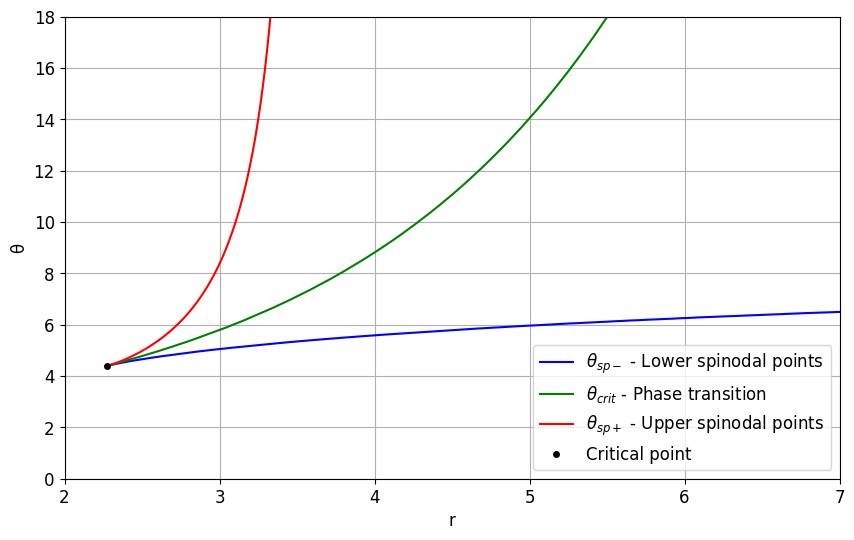

In [114]:
plt.figure(figsize=(10,6))
plt.plot(r_values, transition_thetas_networks[:,0], 'b-', label=r'$\theta_{sp-}$ - Lower spinodal points')
plt.plot(r_values, transition_thetas_networks[:,1], 'g-', label=r'$\theta_{crit}$ - Phase transition') 
plt.plot(r_values, transition_thetas_networks[:,2], 'r-', label=r'$\theta_{sp+}$ - Upper spinodal points')
r_crit = 2.27671753
theta_crit = 4.39935728
plt.plot(r_crit, theta_crit, 'ko', markersize=4, label='Critical point')
plt.grid(True)
plt.xlabel('r')
plt.ylabel('θ')
plt.ylim(0, 18)
plt.xlim(2, 7)
# plt.title('Critical θ values vs r')
# Set the legend to appear at the bottom right
plt.legend(loc='lower right')
plt.show()

#### Figure 4.5 - the irreconstructible link densities

In [ ]:
def find_spinodal_indices(local_minima_arr):
    threshold = 1e-6
    
    # Find indices where local minima differ
    diff_indices = np.where(np.abs(local_minima_arr[:,0] - local_minima_arr[:,1]) > threshold)[0]
    if len(diff_indices) == 0:
        return None, None
    first_diff_idx = diff_indices[0]-1
    last_diff_idx = diff_indices[-1]
    return first_diff_idx, last_diff_idx

In [ ]:
def compute_irreconstructible_densities(local_maxima_arr_all):
    c_low_after_jump_all = np.zeros(len(local_maxima_arr_all))
    c_high_before_jump_all = np.zeros(len(local_maxima_arr_all))
    for i in range(len(local_maxima_arr_all)):
        local_maxima_arr = local_maxima_arr_all[i]
        c_low_jump_index, c_high_jump_index = find_spinodal_indices(local_maxima_arr)
        c_low_after_jump_all[i] = local_maxima_arr[c_low_jump_index + 1, 0] if c_low_jump_index is not None else np.nan
        c_high_before_jump_all[i] = local_maxima_arr[c_high_jump_index, 1] if (c_high_jump_index is not None and c_high_jump_index != 9999) else np.nan
    return c_low_after_jump_all, c_high_before_jump_all

In [ ]:
c_low_after_jump_all, c_high_before_jump_all = compute_irreconstructible_densities(local_maxima_arr_all)

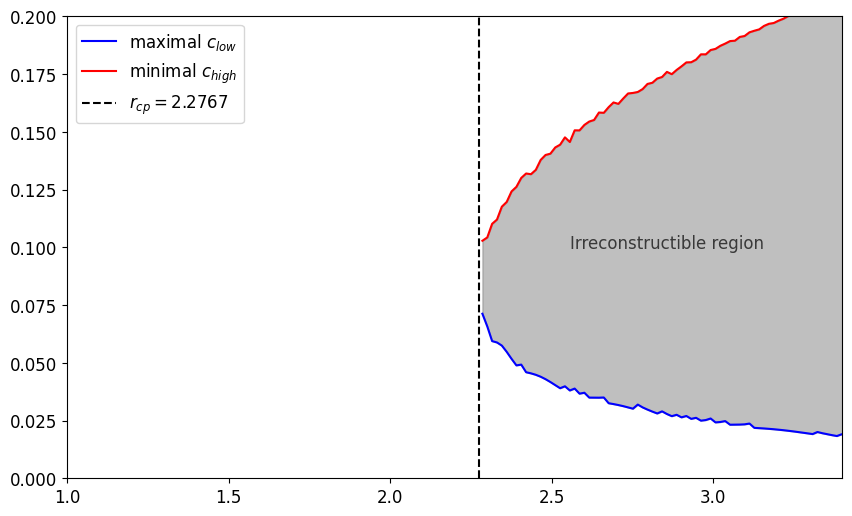

In [117]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

# your two curves
plt.plot(r_values, c_low_after_jump_all, 'b-', label=r'maximal $c_{low}$')
plt.plot(r_values, c_high_before_jump_all, 'r-', label=r'minimal $c_{high}$')

# vertical line
plt.axvline(x=2.2767, color='k', linestyle='--', label=r'$r_{cp}=2.2767$')

# fill between
mask = c_high_before_jump_all > c_low_after_jump_all
plt.fill_between(
    r_values,
    c_low_after_jump_all,
    c_high_before_jump_all,
    where=mask,
    color='grey',
    alpha=0.5,
)

# compute a good spot for the label
# pick the subsection of r where we’ve shaded
r_shaded = r_values[mask]
low_shaded = c_low_after_jump_all[mask]
high_shaded = c_high_before_jump_all[mask]

# take the midpoint of that range
x_text = (r_shaded.min() + r_shaded.max()) / 2
# and halfway between the two curves there (interpolating if needed)
# find the index closest to x_text
idx = np.argmin(np.abs(r_values - x_text))
y_text = (c_low_after_jump_all[idx] + c_high_before_jump_all[idx]) / 2

plt.text(
    x_text, y_text, 'Irreconstructible region',
    color='black',        # more contrast against grey
    fontsize=12,
    ha='center', va='center',
    # backgroundcolor='white',  # optional to improve legibility
    alpha=0.7
)

plt.legend()
plt.xlim(1, 3.4)
plt.ylim(0, 0.2)
plt.show()

### Network properties

Generate ensembles

In [116]:
num_nodes = 100
num_samples = 1000
initial_num_edges = 10
q_values = np.ones(10) - np.linspace(1e-6, 1e-3, 10)
thetas = [1, 3, 5]

In [ ]:
if not os.path.exists('data/ensembles_q_to_1_linear.pkl'):
    ensembles = {}
    for theta in thetas:
        ensembles[theta] = {}
        for q in q_values:
            print(f"Generating ensemble for theta={theta}, q={q}")
            ensemble = generate_tsallis_ensemble(q, [theta], num_nodes, num_samples, initial_num_edges, skip_first_samples=20)
            ensembles[theta][q] = ensemble

    # Create data directory if it doesn't exist
    os.makedirs('data', exist_ok=True)

    # Save ensembles to pickle file
    with open('data/ensembles_q_to_1_linear.pkl', 'wb') as f:
        pickle.dump(ensembles, f)
else:
    with open('data/ensembles_q_to_1_linear.pkl', 'rb') as f:
        ensembles = pickle.load(f)

#### Figure 4.6 - Compare the ensemble average link density with theoretical values

Ensemble averages

In [ ]:
# Function to compute average number of links
def compute_avg_num_links(ensemble):
    return np.mean([graph.ecount() for graph in ensemble])

In [ ]:
# Compute average number of links for each ensemble
avg_num_links = {theta: {} for theta in ensembles.keys()}
for theta in ensembles.keys():
    for q in ensembles[theta]:
        avg_num_links[theta][q] = compute_avg_num_links(ensembles[theta][q])

Linear correction from perturbative approach

In [ ]:
correction_coefficients = np.array([1/2 * theta ** 2 / (1 + np.exp(theta))**2 * np.exp(theta) * (2*num_nodes ** 2 - 1 + np.exp(theta)) for theta in thetas])
linear_corrections_c = 1/(1 + np.exp(thetas).reshape(-1, 1)) * (1 + correction_coefficients.reshape(-1, 1) * (1 - np.array(q_values)))


Solutions of the saddle-point equations

In [ ]:
def saddle_point_equation_q(c, theta, N, q):
    return np.log((1-c)/c) - theta/(1 + (1-q)*theta*N*c)

def find_c(theta, N, q):
    """
    Find c that solves saddle_point_equation_q = 0 for given theta, q and N
    """
    # Define function to find root of
    def func(c):
        return saddle_point_equation_q(c, theta, N, q)
    
    # Find root using scipy optimize
    result = optimize.root_scalar(func, bracket=[1e-10, 1-1e-10], method='brentq')
    
    if result.converged:
        return result.root
    else:
        raise RuntimeError("Root finding did not converge")

In [ ]:
# Get theoretical prediction for number of links
N = num_nodes ** 2
theoretical_c = {}
q_values_theor = np.linspace(1-1e-6, 1-1e-3, 100)
for theta in thetas:
    theoretical_c[theta] = {}
    for q in q_values_theor:
        c = find_c(theta, N, q)
        theoretical_c[theta][q] = c

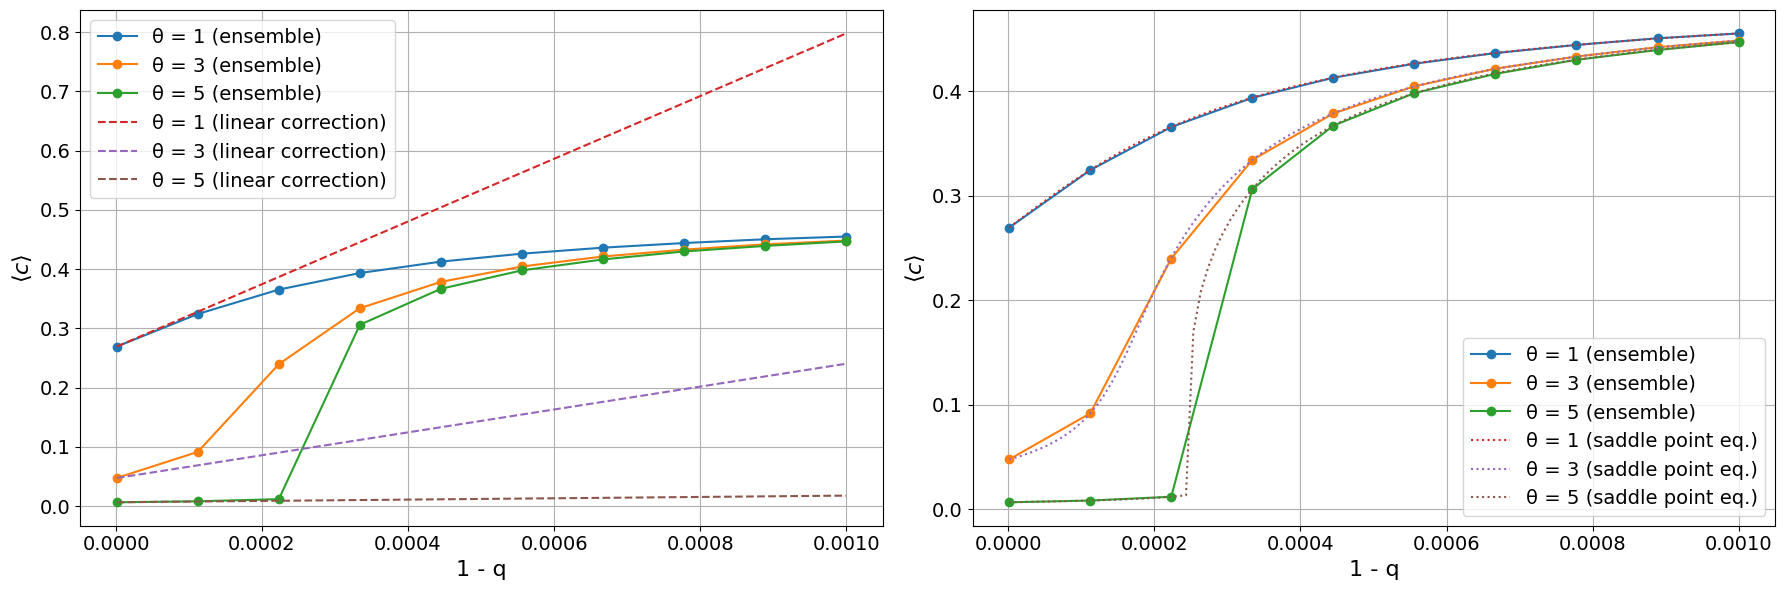

In [ ]:
# Set font sizes
label_fontsize = 16
tick_fontsize = 14
legend_fontsize = 14
title_fontsize = 18

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# --- Left plot: Linear corrections ---
for theta in avg_num_links:
    q_values_plot = sorted(avg_num_links[theta].keys())
    avg_links = [avg_num_links[theta][q] for q in q_values_plot]
    densities = [avg_num_links[theta][q] / num_nodes**2 for q in q_values_plot]
    axes[0].plot(1 - np.array(q_values_plot), densities, marker='o', label=f'θ = {theta} (ensemble)')

for i, theta in enumerate(thetas):
    axes[0].plot(1 - np.array(q_values), linear_corrections_c[i], '--', label=f'θ = {theta} (linear correction)')

axes[0].set_xlabel('1 - q', fontsize=label_fontsize)
axes[0].set_ylabel(r'$\langle c \rangle$', fontsize=label_fontsize)
# axes[0].set_title('Average number of links vs q\n(Linear corrections)', fontsize=title_fontsize)
axes[0].legend(fontsize=legend_fontsize)
axes[0].grid(True)
axes[0].tick_params(axis='both', labelsize=tick_fontsize)

# --- Right plot: Theoretical predictions ---
for theta in avg_num_links:
    avg_links = [avg_num_links[theta][q] for q in q_values]
    densities = [avg_num_links[theta][q] / num_nodes**2 for q in q_values]
    axes[1].plot(1 - np.array(q_values), densities, marker='o', label=f'θ = {theta} (ensemble)')

for theta in theoretical_c:
    c_values = [theoretical_c[theta][q] for q in q_values_theor]
    axes[1].plot(1 - np.array(q_values_theor), c_values, ':', label=f'θ = {theta} (saddle point eq.)')

axes[1].set_xlabel('1 - q', fontsize=label_fontsize)
axes[1].set_ylabel(r'$\langle c \rangle$', fontsize=label_fontsize)
# axes[1].set_title('Average number of links vs q\n(Theoretical predictions)', fontsize=title_fontsize)
axes[1].legend(fontsize=legend_fontsize)
axes[1].grid(True)
axes[1].tick_params(axis='both', labelsize=tick_fontsize)

plt.tight_layout()
plt.show()

#### Figure 4.7 - comparison of distributions of link densities close to and far from phase transition

In [129]:
r = 2.7
theta = 5.154

num_nodes = 100
# r=(1-q)*N
q = 1 - r/num_nodes**2
num_samples = 10000

Near phase transition - two initial conditions leading to two different stable points

In [130]:
initial_num_edges_low_c = 100
initial_num_edges_high_c = 3000

In [131]:
if os.path.exists('data/density_distributions/ensemble_low_c.pkl'):
    with open('data/density_distributions/ensemble_low_c.pkl', 'rb') as f:
        ensemble_low_c = pickle.load(f)
else:
    ensemble_low_c = generate_tsallis_ensemble(q, [theta], num_nodes, num_samples, initial_num_edges_low_c, skip_first_samples=100)
    with open('data/density_distributions/ensemble_low_c.pkl', 'wb') as f:
        pickle.dump(ensemble_low_c, f)

if os.path.exists('data/density_distributions/ensemble_high_c.pkl'):
    with open('data/density_distributions/ensemble_high_c.pkl', 'rb') as f:
        ensemble_high_c = pickle.load(f)
else:
    ensemble_high_c = generate_tsallis_ensemble(q, [theta], num_nodes, num_samples, initial_num_edges_high_c, skip_first_samples=100)
    with open('data/density_distributions/ensemble_high_c.pkl', 'wb') as f:
        pickle.dump(ensemble_high_c, f)


In [133]:
avg_density_low_c = np.mean([graph.ecount() for graph in ensemble_low_c])/num_nodes**2
avg_density_high_c = np.mean([graph.ecount() for graph in ensemble_high_c])/num_nodes**2
print("Low density phase c:", avg_density_low_c)
print("High density phase c:", avg_density_high_c)


Low density phase c: 0.012005440000000001
High density phase c: 0.21731155


Far from phase transition

In [128]:
r = 1000
theta = 1

num_nodes = 100
# r=(1-q)*N
q = 1 - r/num_nodes**2
num_samples = 10000
initial_num_edges_high_c = 1000
if os.path.exists('data/density_distributions/ensemble_tsallis_r_high.pkl'):
    with open('data/density_distributions/ensemble_tsallis_r_high.pkl', 'rb') as f:
        ensemble_tsallis_r_high = pickle.load(f)
else:
    ensemble_tsallis_r_high = generate_tsallis_ensemble(q, [theta], num_nodes, num_samples, initial_num_edges_high_c, skip_first_samples=100)
    with open('data/density_distributions/ensemble_tsallis_r_high.pkl', 'wb') as f:
        pickle.dump(ensemble_tsallis_r_high, f)


In [134]:
avg_density_r_high = np.mean([graph.ecount() for graph in ensemble_tsallis_r_high])/num_nodes**2
print("Far from phase transition c:", avg_density_r_high)

Far from phase transition c: 0.49948702999999994


Corresponding Erdos-Renyi ensembles

In [137]:
def compute_er_theta(target_density):
    """
    Compute the theta parameter for an Erdos-Renyi model given a target density.
    
    In the Erdos-Renyi model, the probability of an edge is:
    p = 1/(1+exp(theta))
    
    This function inverts this relationship to find theta given p.
    
    Args:
        target_density (float): The desired edge density (between 0 and 1)
        
    Returns:
        float: The theta parameter that will produce the target density
    """
    # Ensure the target density is valid
    if target_density <= 0 or target_density >= 1:
        raise ValueError("Target density must be between 0 and 1")
    
    theta = np.log((1 - target_density) / target_density)
    
    return theta

In [138]:
# Compute corresponding Erdos-Renyi parameters theta
er_theta_low_c = compute_er_theta(avg_density_low_c)
er_theta_high_c = compute_er_theta(avg_density_high_c)
er_theta_r_high = compute_er_theta(avg_density_r_high)

In [145]:
from src.shannonian_models import erdos_renyi_ensemble_igraph
ensemble_low_c_er = erdos_renyi_ensemble_igraph(er_theta_low_c, num_nodes, num_samples)
ensemble_high_c_er = erdos_renyi_ensemble_igraph(er_theta_high_c, num_nodes, num_samples)
ensemble_r_high_er = erdos_renyi_ensemble_igraph(er_theta_r_high, num_nodes, num_samples)

In [146]:
# Compute average number of links for each ensemble
avg_num_links_low_c_er = np.mean([graph.ecount() for graph in ensemble_low_c_er])/num_nodes**2
avg_num_links_high_c_er = np.mean([graph.ecount() for graph in ensemble_high_c_er])/num_nodes**2
avg_num_links_r_high_er = np.mean([graph.ecount() for graph in ensemble_r_high_er])/num_nodes**2
print("Low density phase c (ER):", avg_num_links_low_c_er)
print("High density phase c (ER):", avg_num_links_high_c_er)
print("Far from phase transition c (ER):", avg_num_links_r_high_er)


Low density phase c (ER): 0.01200201
High density phase c (ER): 0.21733381
Far from phase transition c (ER): 0.49957918


Compute the histograms

In [147]:
densities_low_c_tsallis = [g.ecount() / num_nodes**2 for g in ensemble_low_c]
densities_high_c_tsallis = [g.ecount() / num_nodes**2 for g in ensemble_high_c]
densities_r_high_tsallis = [g.ecount() / num_nodes**2 for g in ensemble_tsallis_r_high]
densities_low_c_er = [g.ecount() / num_nodes**2 for g in ensemble_low_c_er]
densities_high_c_er = [g.ecount() / num_nodes**2 for g in ensemble_high_c_er]
densities_r_high_er = [g.ecount() / num_nodes**2 for g in ensemble_r_high_er]

# Get shared bins for fair comparison
all_low_c_densities = np.array(densities_low_c_tsallis + densities_low_c_er)
low_c_bins = np.histogram_bin_edges(all_low_c_densities, bins=30)

all_high_c_densities = np.array(densities_high_c_tsallis + densities_high_c_er)
high_c_bins = np.histogram_bin_edges(all_high_c_densities, bins=30)

all_r_high_densities = np.array(densities_r_high_tsallis + densities_r_high_er)
r_high_bins = np.histogram_bin_edges(all_r_high_densities, bins=30)

# Compute histograms
hist_low_c_tsallis, bin_edges_low_c_tsallis = np.histogram(densities_low_c_tsallis, bins=low_c_bins, density=True)
hist_high_c_tsallis, bin_edges_high_c_tsallis = np.histogram(densities_high_c_tsallis, bins=high_c_bins, density=True)

In [148]:
low_c_tsallis_hist, low_c_bin_edges = np.histogram(densities_low_c_tsallis, bins=low_c_bins, density=True)
low_c_er_hist, _ = np.histogram(densities_low_c_er, bins=low_c_bins, density=True)
low_c_bin_centers = 0.5 * (low_c_bin_edges[:-1] + low_c_bin_edges[1:])

high_c_tsallis_hist, high_c_bin_edges = np.histogram(densities_high_c_tsallis, bins=high_c_bins, density=True)
high_c_er_hist, _ = np.histogram(densities_high_c_er, bins=high_c_bins, density=True)
high_c_bin_centers = 0.5 * (high_c_bin_edges[:-1] + high_c_bin_edges[1:])

r_high_tsallis_hist, r_high_bin_edges = np.histogram(densities_r_high_tsallis, bins=r_high_bins, density=True)
r_high_er_hist, _ = np.histogram(densities_r_high_er, bins=r_high_bins, density=True)
r_high_bin_centers = 0.5 * (r_high_bin_edges[:-1] + r_high_bin_edges[1:])


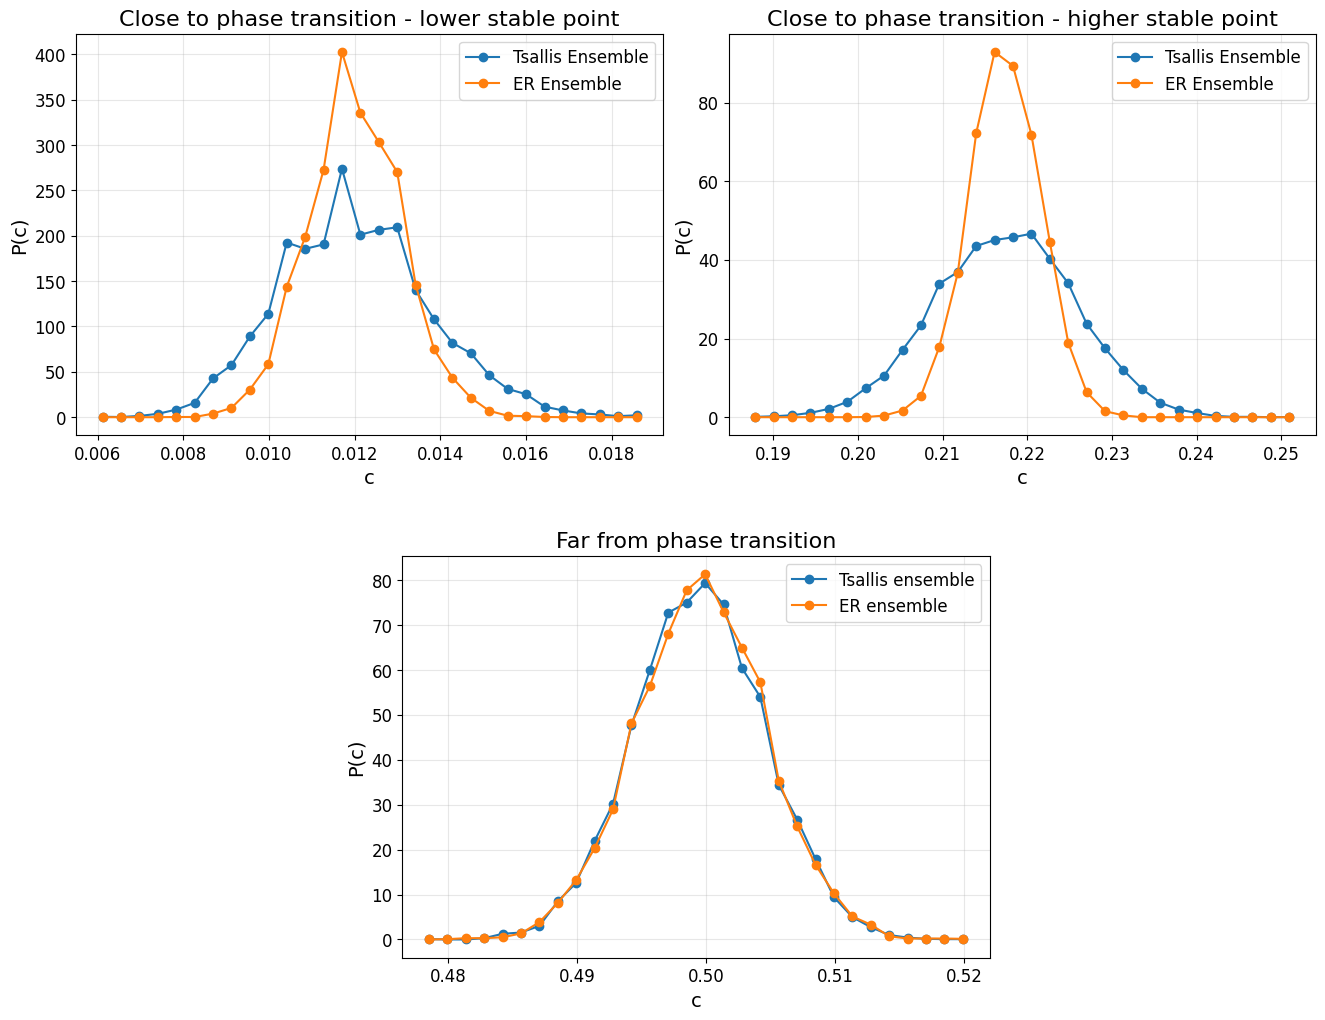

In [149]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(16, 12))

gs = gridspec.GridSpec(2, 4, height_ratios=[1, 1])

# First row: close to phase transition
# First graph takes columns 0-1
ax1 = fig.add_subplot(gs[0, 0:2])
# Second graph takes columns 2-3
ax2 = fig.add_subplot(gs[0, 2:4])

ax1.plot(low_c_bin_centers, low_c_tsallis_hist, '-o', label='Tsallis Ensemble')
ax1.plot(low_c_bin_centers, low_c_er_hist, '-o', label='ER Ensemble')
ax1.set_title('Close to phase transition - lower stable point')
ax1.set_xlabel('c')
ax1.set_ylabel('P(c)')
ax1.legend()
ax1.grid(alpha=0.3)

ax2.plot(high_c_bin_centers, high_c_tsallis_hist, '-o', label='Tsallis Ensemble')
ax2.plot(high_c_bin_centers, high_c_er_hist, '-o', label='ER Ensemble')
ax2.set_title('Close to phase transition - higher stable point')
ax2.set_xlabel('c')
ax2.set_ylabel('P(c)')
ax2.legend()
ax2.grid(alpha=0.3)

# Second row: far from phase transition (centered)
# Bottom graph takes columns 1-2 (middle two columns)
ax3 = fig.add_subplot(gs[1, 1:3])
ax3.plot(r_high_bin_centers, r_high_tsallis_hist, 'o-', label='Tsallis ensemble')
ax3.plot(r_high_bin_centers, r_high_er_hist, 'o-', label='ER ensemble')
ax3.set_xlabel('c')
ax3.set_ylabel('P(c)')
ax3.set_title('Far from phase transition')
ax3.legend()
ax3.grid(alpha=0.3)

# Adjust layout
plt.subplots_adjust(hspace=0.3, wspace=0.25)

plt.show()

Standard deviations comparison

In [150]:
print("Low c comparison:")
print(f"Tsallis mean density: {np.mean(densities_low_c_tsallis):.4f}, std: {np.std(densities_low_c_tsallis):.4f}")
print(f"ER mean density: {np.mean(densities_low_c_er):.4f}, std: {np.std(densities_low_c_er):.4f}")
print("\nHigh c comparison:")
print(f"Tsallis mean density: {np.mean(densities_high_c_tsallis):.4f}, std: {np.std(densities_high_c_tsallis):.4f}")
print(f"ER mean density: {np.mean(densities_high_c_er):.4f}, std: {np.std(densities_high_c_er):.4f}")

Low c comparison:
Tsallis mean density: 0.0120, std: 0.0018
ER mean density: 0.0120, std: 0.0011

High c comparison:
Tsallis mean density: 0.2173, std: 0.0082
ER mean density: 0.2173, std: 0.0041
